# 计算机模拟第六周作业

In [1]:
from __future__ import print_function, division

# 这句话是非标准的python，用于ipthon或jupyter这样的系统中，表示绘图即刻自动展开。
%matplotlib inline

# 这里把全部Warning过滤掉了. 
# 参见https://docs.python.org/2/library/warnings.html
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
np.random.seed(250)

## 椭圆面积估计

椭圆的轨迹为到两个焦点 $(x_1, y_1)$ 和 $(x_2, y_2)$ 距离之和为定长 $L$ 的曲线。由于只是需要计算面积，我们可以通过坐标变换将该椭圆的长轴换到 $x$ 轴上。椭圆的焦距 $c = \sqrt{(x_1-x_2)^2 + (y_1-y_2)^2} / 2$，长轴 $a = L/2$，短轴 $b = \sqrt{(a^2 - c^2)}$。于是，我们可以将该椭圆在第一象限的部分放缩到 $[0, 1] \times [0, 1]$ 矩形内，用于实施 Monte Carlo 算法。计算出投点命中率之后，乘以 $ 4a^2 $ 就得到椭圆面积的无偏估计值，得到的标准误差乘以 $ 16a^4 $ 就得到椭圆面积估计值的标准误差。设 $n$ 为投点次数，$S$ 为投点次数，上述结论可以表示为：

$$ \bar{\lambda}_n = 4a^{2}\frac{S}{n} $$
$$ Var[\bar{\lambda}_n] = \frac{16a^4}{n-1}\frac{S}{n}(1-\frac{S}{n}) $$

In [2]:
# Monte Carlo 方法计算椭圆面积
# 输入：焦点坐标 (x1, y1), (x2, y2), 定长 L， 投点次数 T
# 输出：椭圆面积估计值，对应标准误差
def ellipse_area(x1, y1, x2, y2, L, times):
    # 计算焦距平方，长短轴长的平方
    c2 = (((x1 - x2)**2 + (y1 - y2)**2)) / 4
    a2 = L**2 /4
    b2 = (a2 - c2)
    # 随机投点
    dots = np.random.rand(2, times)
    inside = 0
    for i in range(times):
        # 判断点是否在椭圆内
        d = dots[0, i]**2 + (dots[1, i]**2) * a2 / b2
        if d <= 1:
            inside += 1
        # 计算面积估计值，标准误差
        area = inside/times
    return 4*a2*area, 16*a2*a2*area*(1-area)/(times-1)

假设焦点为 $(1, 1), (-1, 0)$，定长为 $3$，理论上椭圆的面积为 $3\pi/2$，我们可以运行程序得到其面积估计值与估计的标准误差，可以看到估计值与理论值十分接近。

In [6]:
# 投点 100000 次
ellipse_area(1, 1, -1, 0, 3, 100000)

(4.7439, 0.00020190714697146972)

## 面积上下边界

如前所述，将椭圆长轴变换到 $x$ 轴之上，得到的椭圆的参数方程为：

\begin{equation}
\left\{
\begin{array} \
x=a \ cos\theta\\
y=b \ sin\theta\\
\end{array}
\right.
\end{equation}

其中 $\theta \in [0, 2\pi)$。考虑其第一象限的部分，可以得到椭圆的上边界 $[0, a] \times [0, b]$。至于下边界，我们的目标是使其尽量大，于是

$$ \lambda_U = sup_{\theta}\{ab sin\theta cos \theta\} = ab/2.$$

取到最大值时，$\theta = \pi/2$。故有下边界 $[0, a/{\sqrt{2}}] \times [0, b/{\sqrt{2}}]$。下面的程序用拒绝-接受算法 (AR) 抽取落在$\mathscr{R}_U \backslash \mathscr{R}_L$之间随机分布。

In [8]:
# Monte Carlo 方法 + 上下边界筛选计算椭圆面积
# 输入：焦点坐标 (x1, y1), (x2, y2), 定长 L， 投点次数 T
# 输出：椭圆面积估计值，对应标准误差
def ellipse_area_AR(x1, y1, x2, y2, L, times):
    # 计算焦距平方，长短轴长的平方
    c2 = (((x1 - x2)**2 + (y1 - y2)**2)) / 4
    a2 = L**2 /4
    b2 = (a2 - c2)
    # 计算上下边界
    xL = 1/(2**0.5)
    yU = (b2/a2)**0.5
    yL = yU/(2**0.5)
    # 随机投点
    dots = np.random.rand(2, times)
    inside = 0
    for i in range(times):
        # 点在下边界内
        if dots[0, i] <= xL and dots[1, i] <= yL:
            inside += 1
        # 点在上边界内，接着判断是否在椭圆内
        elif dots[1, i] <= yU:
            d = dots[0, i]**2 + (dots[1, i]**2) * a2 / b2
            if d <= 1:
                inside += 1
        # 计算面积估计值，标准误差
        area = inside/times
    return 4*a2*area, 16*a2*a2*area*(1-area)/(times-1)

同样用上面的椭圆来测试我们的程序：

In [10]:
ellipse_area_AR(1, 1, -1, 0, 3, 100000)

(4.720140000000001, 0.0002020174039780398)

最后统计一下实际误差的分布：

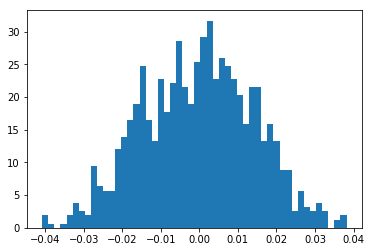

In [12]:
T = 1000
n = 100000
abs_err = np.zeros(T)
for i in range(T):
    abs_err[i] = (ellipse_area_AR(1, 1, -1, 0, 3, 100000)[0] - 3*np.pi/2)
plt.hist(abs_err, bins=50, normed=True, label="Stat. of the Sampling");